# ARCH and GARCH
- Author: Kimberly Yeo
- Module: Capstone
- Date: 2/11/2021

## Import packages

In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from arch import arch_model
from arch.univariate import ARCH, GARCH, ConstantMean, Normal
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, KFold

## Load data

For later iterations and testing, use cctx (it supports live data and multiple exchanges (best one is ftx)).

In [2]:
# Import the data
df = pd.read_csv("BTC-USD.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-09-29,6643.100098,6643.100098,6511.649902,6601.959961,6601.959961,4.363690e+09
1,2018-09-30,6604.709961,6643.779785,6566.540039,6625.560059,6625.560059,4.002280e+09
2,2018-10-01,6619.850098,6653.299805,6549.080078,6589.620117,6589.620117,4.000970e+09
3,2018-10-02,6593.240234,6611.839844,6537.899902,6556.100098,6556.100098,3.979260e+09
4,2018-10-03,6553.859863,6571.459961,6454.029785,6502.589844,6502.589844,3.887310e+09


In [3]:
# Calculate daily returns as percentage price changes
df["Return"] = 100 * (df["Adj Close"].pct_change())
df["Log_Return"] = np.log(df["Adj Close"]).diff().mul(100) # rescale to faciliate optimization
df = df.dropna()

In [6]:
data = df[["Date", "Return"]]
data = data.set_index(data.columns[0])
data.head()

,Return
Date,
2018-09-30,0.357471
2018-10-01,-0.542444
2018-10-02,-0.508679
2018-10-03,-0.816190
2018-10-04,1.139547


## EDA

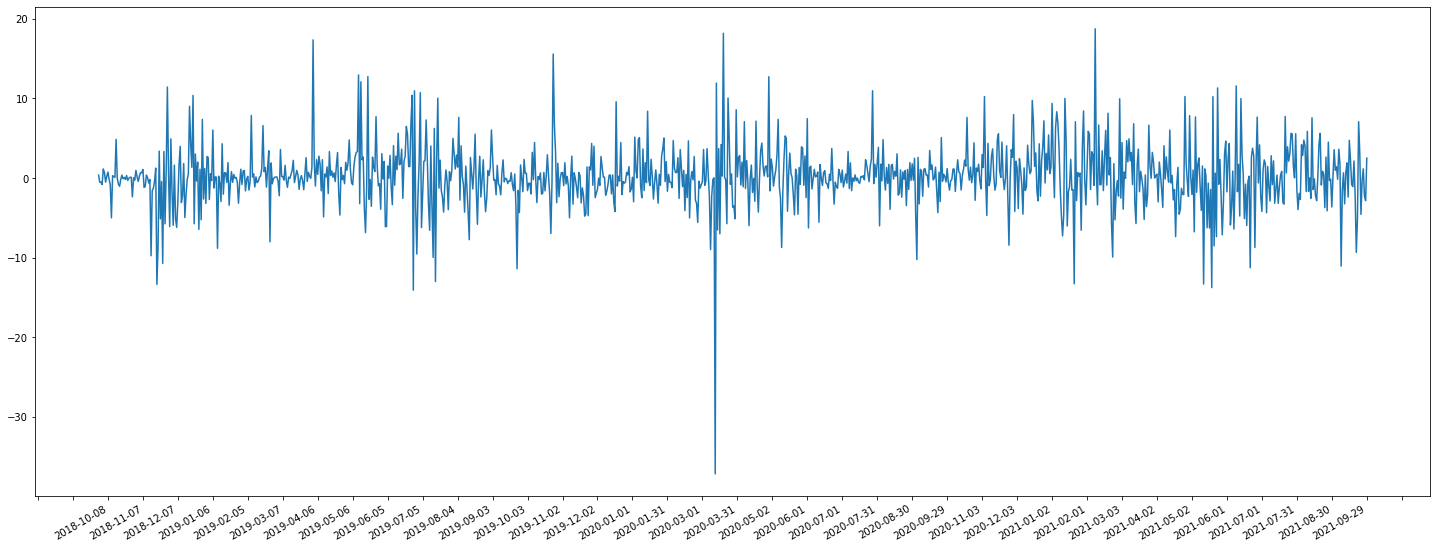

In [5]:
# Plot daily returns
plt.figure(figsize = [25, 10])
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.plot(data)
plt.gcf().autofmt_xdate()
plt.show()

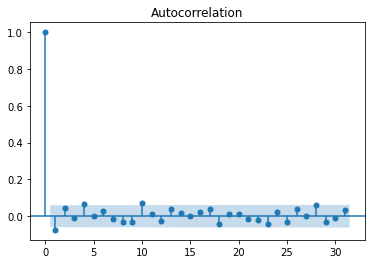

In [6]:
# Plot ACF
plot_acf(data.dropna())
plt.show()

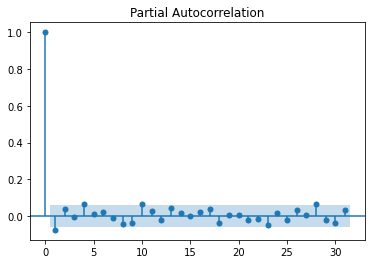

In [7]:
# Plot PACF
plot_pacf(data.dropna())
plt.show()

## ARCH

In [7]:
time_horizon = 6

In [8]:
train = data[:-time_horizon].dropna()
test = data[-time_horizon:].dropna()

In [9]:
# Evaluation metrics
# Taken from ARCH/GARCH Volatility Forecasting notebook
def evaluate(observation, forecast): 
    # Call sklearn function to calculate MAE
    mae = mean_absolute_error(observation, forecast)
    print(f'Mean Absolute Error (MAE): {round(mae,3)}')
    # Call sklearn function to calculate MSE
    mse = mean_squared_error(observation, forecast)
    print(f'Mean Squared Error (MSE): {round(mse,3)}')
    return mae, mse

In [10]:
# Hyperparameter tuning function
def hypertune(mod_type, accur_metric, param_list, time_horizon):
    count = 1
    if mod_type == "arch":
        for i in param_list[0]:
            am = arch_model(train, mean='Zero', vol='ARCH', p=i)
            am_fit = am.fit()
            am_yhat = am_fit.forecast(horizon=time_horizon)
            arch_vol = pd.DataFrame(np.sqrt(am_yhat.variance.values[-1:]).transpose())
            arch_vol.index = test.index
            arch_vol = arch_vol.rename(columns={0: "Volatility"})
            mae, mse = evaluate(data.sub(data.mean()).pow(2)[-time_horizon:], arch_vol**2)
            if accur_metric == "mae":
                if count == 1:
                    min_mae = mae
                    p_val = i
                else:
                    if mae < min_mae:
                        min_mae = mae
                        p_val = i
            else:
                if count == 1:
                    min_mse = mse
                    p_val = i
                else:
                    if mse < min_mse:
                        min_mse = mse
                        p_val = i
            count += 1
        return p_val
    if mod_type == "garch":
        for i in param_list[0]:
            for j in param_list[1]:
                gm = arch_model(train, mean='Zero', vol='GARCH', p=i, q=j)
                gm_fit = gm.fit()
                gm_yhat = gm_fit.forecast(horizon=time_horizon)
                garch_vol = pd.DataFrame(np.sqrt(gm_yhat.variance.values[-1:]).transpose())
                garch_vol.index = test.index
                garch_vol.rename(columns={0: "Volatility"})
                mae, mse = evaluate(data.sub(data.mean()).pow(2)[-time_horizon:], garch_vol**2)
                if accur_metric == "mae":
                    if count == 1:
                        min_mae = mae
                        p_val = i
                        q_val = j
                    else:
                        if mae < min_mae:
                            min_mae = mae
                            p_val = i
                            q_val = j
                else:
                    if count == 1:
                        min_mse = mse
                        p_val = i
                        q_val = j
                    else:
                        if mse < min_mse:
                            min_mse = mse
                            p_val = i
                            q_val = j
                count += 1
        return p_val, q_val 
    if mod_type == "gjr_garch":
        for i in param_list[0]:
            for j in param_list[1]:
                for k in param_list[2]:
                    gjr_gm = arch_model(train, p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't')
                    gjr_gm_fit = gjr_gm.fit()
                    gjr_gm_yhat = gjr_gm_fit.forecast(horizon=time_horizon)
                    gjrgm_vol = pd.DataFrame(np.sqrt(gjr_gm_yhat.variance.values[-1:]).transpose())
                    gjrgm_vol.index = test.index
                    gjrgm_vol = gjrgm_vol.rename(columns={0: "Volatility"})
                    mae, mse = evaluate(data.sub(data.mean()).pow(2)[-time_horizon:], gjrgm_vol**2)
                    if accur_metric == "mae":
                        if count == 1:
                            min_mae = mae
                            p_val = i
                            q_val = j
                            o_val = k
                        else:
                            if mae < min_mae:
                                min_mae = mae
                                p_val = i
                                q_val = j
                    else:
                        if count == 1:
                            min_mse = mse
                            p_val = i
                            q_val = j
                            o_val = k
                        else:
                            if mse < min_mse:
                                min_mse = mse
                                p_val = i
                                q_val = j
                    count += 1
        return p_val, q_val, o_val

In [12]:
param_list = [[1, 2, 3, 4, 5, 6]]
hypertune("arch", "mae", param_list, time_horizon)

Iteration:      1,   Func. Count:      4,   Neg. LLF: 3016.720347674265
Iteration:      2,   Func. Count:      8,   Neg. LLF: 3321.2003954099036
Iteration:      3,   Func. Count:     14,   Neg. LLF: 3012.181984949772
Iteration:      4,   Func. Count:     18,   Neg. LLF: 3011.882907485459
Iteration:      5,   Func. Count:     21,   Neg. LLF: 3011.8828330057913
Iteration:      6,   Func. Count:     24,   Neg. LLF: 3011.882826702018
Iteration:      7,   Func. Count:     26,   Neg. LLF: 3011.8828267020276
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3011.882826702018
            Iterations: 7
            Function evaluations: 26
            Gradient evaluations: 7
Mean Absolute Error (MAE): 10.487
Mean Squared Error (MSE): 120.976
Iteration:      1,   Func. Count:      5,   Neg. LLF: 3071.597679956554
Iteration:      2,   Func. Count:     11,   Neg. LLF: 3011.531688482687
Iteration:      3,   Func. Count:     16,   Neg. LLF: 5141.288631700401
It

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      6,   Func. Count:     51,   Neg. LLF: 2968.0556206293504
Iteration:      7,   Func. Count:     59,   Neg. LLF: 2965.2641426806167
Iteration:      8,   Func. Count:     67,   Neg. LLF: 2971.229324207594
Iteration:      9,   Func. Count:     75,   Neg. LLF: 2964.290956864338
Iteration:     10,   Func. Count:     83,   Neg. LLF: 2962.3918594135466
Iteration:     11,   Func. Count:     91,   Neg. LLF: 2962.3786579517564
Iteration:     12,   Func. Count:     98,   Neg. LLF: 2962.377833018116
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2962.377833018377
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2962.377833018116
            Iterations: 13
            Function evaluations: 104
            Gradient evaluations: 13
Mean Absolute Error (MAE): 19.524
Mean Squared Error (MSE): 415.876
Iteration:      1,   Func. Count:      9,   Neg. LLF: 3011.2362650424047
Iteration:      2,   Func. Count:     19,   Neg. LLF: 9648.5629681137

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


2

In [11]:
# Define the model
am = arch_model(train, mean='Zero', vol='ARCH', p=2)
# arch_model = arch_model(train, vol='ARCH', p=1)
# model = arch_model(data, mean='Zero', vol='ARCH', p=1)
# Fit model
am_fit = am.fit()
# Forecast the test set
am_yhat = am_fit.forecast(horizon=time_horizon)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 3071.597679956554
Iteration:      2,   Func. Count:     11,   Neg. LLF: 3011.531688482687
Iteration:      3,   Func. Count:     16,   Neg. LLF: 5141.288631700401
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3007.1415471057617
Iteration:      5,   Func. Count:     27,   Neg. LLF: 3007.083799572988
Iteration:      6,   Func. Count:     31,   Neg. LLF: 3007.0812137555963
Iteration:      7,   Func. Count:     35,   Neg. LLF: 3007.0811597555858
Iteration:      8,   Func. Count:     39,   Neg. LLF: 3007.081159089614
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3007.081159089614
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 8


/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


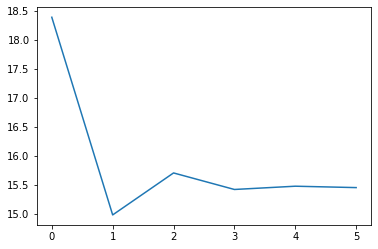

In [12]:
# Plot forecast variance
plt.plot(am_yhat.variance.values[-1, :])
plt.show()

In [13]:
print(am_fit.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -3007.08
Distribution:                  Normal   AIC:                           6020.16
Method:            Maximum Likelihood   BIC:                           6035.12
                                        No. Observations:                 1083
Date:                Fri, Apr 01 2022   Df Residuals:                     1083
Time:                        19:12:06   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         13.5644      2.261      5.999  1.986e-09 

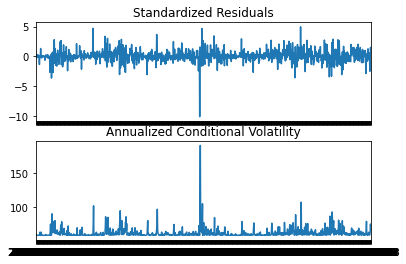

In [33]:
fig = am_fit.plot(annualize="D")

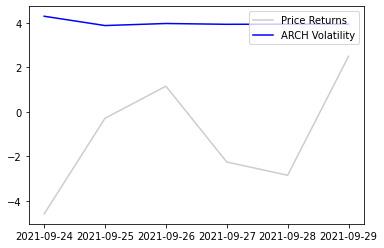

In [14]:
# Plotting estimated ARCH volatility against actual price returns
arch_vol = pd.DataFrame(np.sqrt(am_yhat.variance.values[-1:]).transpose())
arch_vol.index = test.index
arch_vol = arch_vol.rename(columns={0: "Volatility"})

# Plot the actual Bitcoin returns
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.plot(test['Return'], color = 'grey', alpha = 0.4, label = 'Price Returns')

# Plot ARCH estimated volatility
plt.plot(arch_vol, color = 'blue', label = 'ARCH Volatility')

plt.legend(loc = 'upper right')
plt.show()

In [35]:
# Backtest model with MAE, MSE
print("ARCH")
evaluate(data.sub(data.mean()).pow(2)[-time_horizon:], arch_vol**2)

ARCH
Mean Absolute Error (MAE): 9.995
Mean Squared Error (MSE): 114.844


(9.995314843681621, 114.84400441943836)

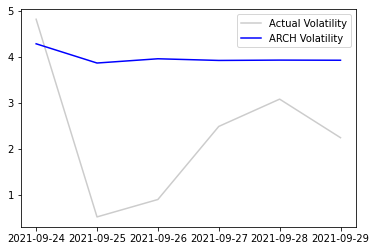

In [21]:
# Plotting estimated ARCH volatility against actual volatility
actual_vol = np.sqrt(data.sub(data.mean()).pow(2))[-time_horizon:]
actual_vol = actual_vol.rename(columns={"Return": "Volatility"})

# Plot the actual Bitcoin volatility
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.plot(actual_vol['Volatility'], color = 'grey', alpha = 0.4, label = 'Actual Volatility')

# Plot ARCH estimated volatility
plt.plot(arch_vol, color = 'blue', label = 'ARCH Volatility')

plt.legend(loc = 'upper right')
plt.show()

## GARCH

In [37]:
param_list = [[8, 9, 10, 14], [16, 18, 20, 22, 24]]
hypertune("garch", "mae", param_list, time_horizon)

Iteration:      1,   Func. Count:     27,   Neg. LLF: 3726.7800952016387
Iteration:      2,   Func. Count:     54,   Neg. LLF: 12637.920588499836
Iteration:      3,   Func. Count:     82,   Neg. LLF: 3144.8947961858676
Iteration:      4,   Func. Count:    110,   Neg. LLF: 13505.931409003639
Iteration:      5,   Func. Count:    138,   Neg. LLF: 5570.736990791012
Iteration:      6,   Func. Count:    166,   Neg. LLF: 3038.533184904637
Iteration:      7,   Func. Count:    193,   Neg. LLF: 2961.689767729109
Iteration:      8,   Func. Count:    220,   Neg. LLF: 2967.943939507245
Iteration:      9,   Func. Count:    248,   Neg. LLF: 3003.386419086479
Iteration:     10,   Func. Count:    275,   Neg. LLF: 3649.494490050666
Iteration:     11,   Func. Count:    303,   Neg. LLF: 2958.895640969182
Iteration:     12,   Func. Count:    330,   Neg. LLF: 2997.4054362132874
Iteration:     13,   Func. Count:    357,   Neg. LLF: 2942.906513926212
Iteration:     14,   Func. Count:    384,   Neg. LLF: 2939.

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      4,   Func. Count:    118,   Neg. LLF: 5631.488282378621
Iteration:      5,   Func. Count:    148,   Neg. LLF: 3125.859756647004
Iteration:      6,   Func. Count:    178,   Neg. LLF: 2991.725828747467
Iteration:      7,   Func. Count:    207,   Neg. LLF: 2962.8257691101758
Iteration:      8,   Func. Count:    236,   Neg. LLF: 2993.756093075315
Iteration:      9,   Func. Count:    266,   Neg. LLF: 2992.552864998276
Iteration:     10,   Func. Count:    295,   Neg. LLF: 3002.0763011832964
Iteration:     11,   Func. Count:    324,   Neg. LLF: 3060.950447346886
Iteration:     12,   Func. Count:    353,   Neg. LLF: 2990.7612508368848
Iteration:     13,   Func. Count:    382,   Neg. LLF: 2951.862996201897
Iteration:     14,   Func. Count:    411,   Neg. LLF: 2947.2028014826496
Iteration:     15,   Func. Count:    440,   Neg. LLF: 2939.072233839119
Iteration:     16,   Func. Count:    468,   Neg. LLF: 2939.1866138771447
Iteration:     17,   Func. Count:    497,   Neg. LLF: 2939.

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:     31,   Neg. LLF: 3704.067289256038
Iteration:      2,   Func. Count:     62,   Neg. LLF: 12527.72086419454
Iteration:      3,   Func. Count:     94,   Neg. LLF: 3782.235785679147
Iteration:      4,   Func. Count:    125,   Neg. LLF: 6040.753966605671
Iteration:      5,   Func. Count:    157,   Neg. LLF: 3008.6932983993047
Iteration:      6,   Func. Count:    189,   Neg. LLF: 2978.0036611853175
Iteration:      7,   Func. Count:    220,   Neg. LLF: 2972.742189361259
Iteration:      8,   Func. Count:    251,   Neg. LLF: 2988.4059776175854
Iteration:      9,   Func. Count:    282,   Neg. LLF: 3478.0861047777294
Iteration:     10,   Func. Count:    313,   Neg. LLF: 2972.5595479749145
Iteration:     11,   Func. Count:    344,   Neg. LLF: 2954.3956948289288
Iteration:     12,   Func. Count:    375,   Neg. LLF: 2962.488826620526
Iteration:     13,   Func. Count:    406,   Neg. LLF: 2957.7936010906947
Iteration:     14,   Func. Count:    437,   Neg. LLF: 294

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(



Mean Squared Error (MSE): 311.243
Iteration:      1,   Func. Count:     33,   Neg. LLF: 3683.2751456955534
Iteration:      2,   Func. Count:     66,   Neg. LLF: 12494.999063078883
Iteration:      3,   Func. Count:    100,   Neg. LLF: 5616.385770960878
Iteration:      4,   Func. Count:    133,   Neg. LLF: 3236.650243225461
Iteration:      5,   Func. Count:    166,   Neg. LLF: 3002.905590460937
Iteration:      6,   Func. Count:    201,   Neg. LLF: 2970.4787781020377
Iteration:      7,   Func. Count:    234,   Neg. LLF: 3020.471907841137
Iteration:      8,   Func. Count:    267,   Neg. LLF: 2986.328347549365
Iteration:      9,   Func. Count:    300,   Neg. LLF: 3126.574566794642
Iteration:     10,   Func. Count:    333,   Neg. LLF: 3235.1745857009264
Iteration:     11,   Func. Count:    366,   Neg. LLF: 3015.841269752377
Iteration:     12,   Func. Count:    399,   Neg. LLF: 2957.112318881891
Iteration:     13,   Func. Count:    432,   Neg. LLF: 2949.233513104027
Iteration:     14,   Func

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:     35,   Neg. LLF: 3652.2030279148466
Iteration:      2,   Func. Count:     70,   Neg. LLF: 12406.206326746627
Iteration:      3,   Func. Count:    106,   Neg. LLF: 18630.045396294117
Iteration:      4,   Func. Count:    142,   Neg. LLF: 4972.684334322341
Iteration:      5,   Func. Count:    177,   Neg. LLF: 3093.0046594637442
Iteration:      6,   Func. Count:    214,   Neg. LLF: 3034.469540539477
Iteration:      7,   Func. Count:    250,   Neg. LLF: 2978.979815329167
Iteration:      8,   Func. Count:    285,   Neg. LLF: 2967.6243799980766
Iteration:      9,   Func. Count:    320,   Neg. LLF: 3066.5600989748464
Iteration:     10,   Func. Count:    355,   Neg. LLF: 2999.574403389341
Iteration:     11,   Func. Count:    390,   Neg. LLF: 2987.614822158295
Iteration:     12,   Func. Count:    425,   Neg. LLF: 2947.7250144076156
Iteration:     13,   Func. Count:    460,   Neg. LLF: 2951.3557994010134
Iteration:     14,   Func. Count:    495,   Neg. LLF: 29

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     11,   Func. Count:    314,   Neg. LLF: 2966.615903224453
Iteration:     12,   Func. Count:    342,   Neg. LLF: 2942.1191789612094
Iteration:     13,   Func. Count:    369,   Neg. LLF: 2940.7775427207407
Iteration:     14,   Func. Count:    396,   Neg. LLF: 3003.0614825360244
Iteration:     15,   Func. Count:    425,   Neg. LLF: 3018.611248419
Iteration:     16,   Func. Count:    453,   Neg. LLF: 2940.4989994183898
Iteration:     17,   Func. Count:    481,   Neg. LLF: 2939.076637867203
Iteration:     18,   Func. Count:    508,   Neg. LLF: 2938.989594280846
Iteration:     19,   Func. Count:    535,   Neg. LLF: 2938.9821297442813
Iteration:     20,   Func. Count:    562,   Neg. LLF: 2938.9738566322203
Iteration:     21,   Func. Count:    589,   Neg. LLF: 2938.973798339548
Iteration:     22,   Func. Count:    616,   Neg. LLF: 2938.973795933808
Iteration:     23,   Func. Count:    642,   Neg. LLF: 2938.9737970368788
Optimization terminated successfully    (Exit mode 0)
      

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Mean Absolute Error (MAE): 16.369
Mean Squared Error (MSE): 311.199
Iteration:      1,   Func. Count:     30,   Neg. LLF: 3469.9178855656764
Iteration:      2,   Func. Count:     60,   Neg. LLF: 12251.843736581315
Iteration:      3,   Func. Count:     91,   Neg. LLF: 3099.2115617117734
Iteration:      4,   Func. Count:    122,   Neg. LLF: 52141.251697466185
Iteration:      5,   Func. Count:    153,   Neg. LLF: 4983.207834428366
Iteration:      6,   Func. Count:    184,   Neg. LLF: 3205.222887035605
Iteration:      7,   Func. Count:    216,   Neg. LLF: 2967.4227120017454
Iteration:      8,   Func. Count:    247,   Neg. LLF: 3012.1867388103283
Iteration:      9,   Func. Count:    277,   Neg. LLF: 2964.2680155036514
Iteration:     10,   Func. Count:    307,   Neg. LLF: 2983.4974660104835
Iteration:     11,   Func. Count:    337,   Neg. LLF: 3098.5734445808566
Iteration:     12,   Func. Count:    367,   Neg. LLF: 3041.7007495401785
Iteration:     13,   Func. Count:    398,   Neg. LLF: 2940

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      2,   Func. Count:     64,   Neg. LLF: 12255.851969101404
Iteration:      3,   Func. Count:     97,   Neg. LLF: 3128.639714184511
Iteration:      4,   Func. Count:    130,   Neg. LLF: 69280.5189308637
Iteration:      5,   Func. Count:    163,   Neg. LLF: 6208.701711054628
Iteration:      6,   Func. Count:    196,   Neg. LLF: 3226.8600576466197
Iteration:      7,   Func. Count:    230,   Neg. LLF: 3019.8375379585596
Iteration:      8,   Func. Count:    263,   Neg. LLF: 3026.213243777729
Iteration:      9,   Func. Count:    295,   Neg. LLF: 2960.7584495853794
Iteration:     10,   Func. Count:    327,   Neg. LLF: 2956.0589915191913
Iteration:     11,   Func. Count:    359,   Neg. LLF: 2992.9919711543707
Iteration:     12,   Func. Count:    391,   Neg. LLF: 2964.7115251090217
Iteration:     13,   Func. Count:    423,   Neg. LLF: 2990.652305359855
Iteration:     14,   Func. Count:    455,   Neg. LLF: 2939.270521981121
Iteration:     15,   Func. Count:    486,   Neg. LLF: 2939

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      7,   Func. Count:    244,   Neg. LLF: 3066.7440385768414
Iteration:      8,   Func. Count:    279,   Neg. LLF: 3026.517994482416
Iteration:      9,   Func. Count:    313,   Neg. LLF: 2964.594725927807
Iteration:     10,   Func. Count:    347,   Neg. LLF: 2955.1351637873227
Iteration:     11,   Func. Count:    381,   Neg. LLF: 2953.581800398296
Iteration:     12,   Func. Count:    415,   Neg. LLF: 3024.2296719267642
Iteration:     13,   Func. Count:    449,   Neg. LLF: 3009.0907597029823
Iteration:     14,   Func. Count:    483,   Neg. LLF: 2946.167106347461
Iteration:     15,   Func. Count:    517,   Neg. LLF: 2938.16890873989
Iteration:     16,   Func. Count:    550,   Neg. LLF: 2952.3520108688253
Iteration:     17,   Func. Count:    585,   Neg. LLF: 2938.4181096852444
Iteration:     18,   Func. Count:    619,   Neg. LLF: 2938.102852968697
Iteration:     19,   Func. Count:    652,   Neg. LLF: 2938.1013471153856
Iteration:     20,   Func. Count:    685,   Neg. LLF: 2938

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      3,   Func. Count:    109,   Neg. LLF: 5180.824108886035
Iteration:      4,   Func. Count:    145,   Neg. LLF: 14072.703600653917
Iteration:      5,   Func. Count:    182,   Neg. LLF: 3071.6675223445463
Iteration:      6,   Func. Count:    219,   Neg. LLF: 6008.2252839339035
Iteration:      7,   Func. Count:    257,   Neg. LLF: 3031.2210989767327
Iteration:      8,   Func. Count:    293,   Neg. LLF: 2997.648997564593
Iteration:      9,   Func. Count:    329,   Neg. LLF: 2979.866392112523
Iteration:     10,   Func. Count:    365,   Neg. LLF: 2983.8542122234917
Iteration:     11,   Func. Count:    401,   Neg. LLF: 2947.0403972801832
Iteration:     12,   Func. Count:    437,   Neg. LLF: 2984.9865269842217
Iteration:     13,   Func. Count:    473,   Neg. LLF: 2979.937886859184
Iteration:     14,   Func. Count:    509,   Neg. LLF: 2943.493206356891
Iteration:     15,   Func. Count:    545,   Neg. LLF: 2941.0602283043836
Iteration:     16,   Func. Count:    581,   Neg. LLF: 29

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(



Iteration:      3,   Func. Count:     88,   Neg. LLF: 3079.629433762728
Iteration:      4,   Func. Count:    118,   Neg. LLF: 508498.1679845595
Iteration:      5,   Func. Count:    148,   Neg. LLF: 3372.887163212529
Iteration:      6,   Func. Count:    178,   Neg. LLF: 3336.8369286483467
Iteration:      7,   Func. Count:    209,   Neg. LLF: 3014.8372974955305
Iteration:      8,   Func. Count:    238,   Neg. LLF: 2996.867280380535
Iteration:      9,   Func. Count:    268,   Neg. LLF: 2968.551506663407
Iteration:     10,   Func. Count:    297,   Neg. LLF: 2954.5252443570275
Iteration:     11,   Func. Count:    326,   Neg. LLF: 2966.031800789157
Iteration:     12,   Func. Count:    355,   Neg. LLF: 3051.0321998338472
Iteration:     13,   Func. Count:    384,   Neg. LLF: 2939.305311862523
Iteration:     14,   Func. Count:    412,   Neg. LLF: 2952.4260911310957
Iteration:     15,   Func. Count:    442,   Neg. LLF: 2944.0359496685455
Iteration:     16,   Func. Count:    471,   Neg. LLF: 293

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      3,   Func. Count:     94,   Neg. LLF: 3090.0236958336363
Iteration:      4,   Func. Count:    126,   Neg. LLF: 387821.0287468539
Iteration:      5,   Func. Count:    158,   Neg. LLF: 3151.280896835739
Iteration:      6,   Func. Count:    190,   Neg. LLF: 3393.8866086599114
Iteration:      7,   Func. Count:    223,   Neg. LLF: 3019.443905917527
Iteration:      8,   Func. Count:    254,   Neg. LLF: 2971.996679763227
Iteration:      9,   Func. Count:    286,   Neg. LLF: 2965.9245113919483
Iteration:     10,   Func. Count:    317,   Neg. LLF: 2958.642817699726
Iteration:     11,   Func. Count:    348,   Neg. LLF: 3238.0649349408163
Iteration:     12,   Func. Count:    379,   Neg. LLF: 3057.612220057632
Iteration:     13,   Func. Count:    410,   Neg. LLF: 2949.3563535419894
Iteration:     14,   Func. Count:    441,   Neg. LLF: 2941.1779794263584
Iteration:     15,   Func. Count:    471,   Neg. LLF: 2939.3982301430588
Iteration:     16,   Func. Count:    501,   Neg. LLF: 296

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      8,   Func. Count:    270,   Neg. LLF: 2999.51908660521
Iteration:      9,   Func. Count:    303,   Neg. LLF: 3004.8988188331377
Iteration:     10,   Func. Count:    336,   Neg. LLF: 3197.2277120505782
Iteration:     11,   Func. Count:    369,   Neg. LLF: 3077.551391003797
Iteration:     12,   Func. Count:    402,   Neg. LLF: 2956.0970191915203
Iteration:     13,   Func. Count:    435,   Neg. LLF: 2964.9207835461107
Iteration:     14,   Func. Count:    468,   Neg. LLF: 2939.7181813678744
Iteration:     15,   Func. Count:    500,   Neg. LLF: 2939.1298334798803
Iteration:     16,   Func. Count:    532,   Neg. LLF: 2939.6918214405396
Iteration:     17,   Func. Count:    565,   Neg. LLF: 2940.940774920342
Iteration:     18,   Func. Count:    598,   Neg. LLF: 2938.9902497745456
Iteration:     19,   Func. Count:    630,   Neg. LLF: 2938.9780676428136
Iteration:     20,   Func. Count:    662,   Neg. LLF: 2938.974130475801
Iteration:     21,   Func. Count:    694,   Neg. LLF: 29

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      5,   Func. Count:    177,   Neg. LLF: 3039.6177208672625
Iteration:      6,   Func. Count:    213,   Neg. LLF: 3485.8944126957963
Iteration:      7,   Func. Count:    248,   Neg. LLF: 2976.8222296268623
Iteration:      8,   Func. Count:    283,   Neg. LLF: 3053.5433087750052
Iteration:      9,   Func. Count:    318,   Neg. LLF: 2979.978895972994
Iteration:     10,   Func. Count:    353,   Neg. LLF: 2962.758243438688
Iteration:     11,   Func. Count:    388,   Neg. LLF: 2959.7911112402107
Iteration:     12,   Func. Count:    424,   Neg. LLF: 3011.037259492628
Iteration:     13,   Func. Count:    459,   Neg. LLF: 3021.4563322106683
Iteration:     14,   Func. Count:    494,   Neg. LLF: 2950.669430303412
Iteration:     15,   Func. Count:    529,   Neg. LLF: 2964.4983246034726
Iteration:     16,   Func. Count:    564,   Neg. LLF: 2939.557731007182
Iteration:     17,   Func. Count:    598,   Neg. LLF: 2941.9302750273514
Iteration:     18,   Func. Count:    633,   Neg. LLF: 29

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(



Mean Squared Error (MSE): 296.387
Iteration:      1,   Func. Count:     37,   Neg. LLF: 3333.527098775373
Iteration:      2,   Func. Count:     74,   Neg. LLF: 12004.91253416294
Iteration:      3,   Func. Count:    112,   Neg. LLF: 17553.9613465382
Iteration:      4,   Func. Count:    150,   Neg. LLF: 3278.814203856242
Iteration:      5,   Func. Count:    187,   Neg. LLF: 3063.2759376969466
Iteration:      6,   Func. Count:    225,   Neg. LLF: 9235.644205353383
Iteration:      7,   Func. Count:    262,   Neg. LLF: 3024.2640425005147
Iteration:      8,   Func. Count:    299,   Neg. LLF: 2986.5691295691277
Iteration:      9,   Func. Count:    336,   Neg. LLF: 2999.3822401282537
Iteration:     10,   Func. Count:    373,   Neg. LLF: 3104.0932104132016
Iteration:     11,   Func. Count:    410,   Neg. LLF: 2975.580020880637
Iteration:     12,   Func. Count:    448,   Neg. LLF: 2975.575681715043
Iteration:     13,   Func. Count:    485,   Neg. LLF: 2964.4417615790144
Iteration:     14,   Fun

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      9,   Func. Count:    300,   Neg. LLF: 3088.423794335621
Iteration:     10,   Func. Count:    334,   Neg. LLF: 2994.921587800952
Iteration:     11,   Func. Count:    367,   Neg. LLF: 3183.117644712009
Iteration:     12,   Func. Count:    400,   Neg. LLF: 2997.799627131987
Iteration:     13,   Func. Count:    433,   Neg. LLF: 2967.607679057681
Iteration:     14,   Func. Count:    466,   Neg. LLF: 2956.40773050167
Iteration:     15,   Func. Count:    499,   Neg. LLF: 3006.901075317428
Iteration:     16,   Func. Count:    533,   Neg. LLF: 2948.7356648605137
Iteration:     17,   Func. Count:    566,   Neg. LLF: 2939.5234089936403
Iteration:     18,   Func. Count:    598,   Neg. LLF: 2939.865600197012
Iteration:     19,   Func. Count:    631,   Neg. LLF: 2939.027219983896
Iteration:     20,   Func. Count:    663,   Neg. LLF: 2939.0627843179122
Iteration:     21,   Func. Count:    696,   Neg. LLF: 2939.572459096786
Iteration:     22,   Func. Count:    729,   Neg. LLF: 2938.977

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:     35,   Neg. LLF: 3148.6336644745916
Iteration:      2,   Func. Count:     70,   Neg. LLF: 3075.608370599184
Iteration:      3,   Func. Count:    106,   Neg. LLF: 3114.3997026626835
Iteration:      4,   Func. Count:    142,   Neg. LLF: 3173.606670228607
Iteration:      5,   Func. Count:    177,   Neg. LLF: 3577.7307807652724
Iteration:      6,   Func. Count:    212,   Neg. LLF: 3445.4681677132357
Iteration:      7,   Func. Count:    247,   Neg. LLF: 2993.250432093696
Iteration:      8,   Func. Count:    282,   Neg. LLF: 2995.0721970536124
Iteration:      9,   Func. Count:    317,   Neg. LLF: 2957.189230594292
Iteration:     10,   Func. Count:    352,   Neg. LLF: 2969.490041424716
Iteration:     11,   Func. Count:    387,   Neg. LLF: 2954.0903919357816
Iteration:     12,   Func. Count:    422,   Neg. LLF: 3074.8484408529075
Iteration:     13,   Func. Count:    458,   Neg. LLF: 2980.397095443828
Iteration:     14,   Func. Count:    494,   Neg. LLF: 294

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      2,   Func. Count:     74,   Neg. LLF: 3076.245604727962
Iteration:      3,   Func. Count:    112,   Neg. LLF: 3115.6326743759764
Iteration:      4,   Func. Count:    150,   Neg. LLF: 3175.284809357864
Iteration:      5,   Func. Count:    187,   Neg. LLF: 3397.6555466388804
Iteration:      6,   Func. Count:    224,   Neg. LLF: 3268.557239782166
Iteration:      7,   Func. Count:    261,   Neg. LLF: 3140.7035418431747
Iteration:      8,   Func. Count:    298,   Neg. LLF: 2958.419495211806
Iteration:      9,   Func. Count:    335,   Neg. LLF: 2997.4909867053684
Iteration:     10,   Func. Count:    373,   Neg. LLF: 2953.4864900781877
Iteration:     11,   Func. Count:    410,   Neg. LLF: 2968.123127552096
Iteration:     12,   Func. Count:    448,   Neg. LLF: 2943.375540995209
Iteration:     13,   Func. Count:    485,   Neg. LLF: 2952.8392078488782
Iteration:     14,   Func. Count:    522,   Neg. LLF: 2980.097489220403
Iteration:     15,   Func. Count:    560,   Neg. LLF: 2950

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      2,   Func. Count:     78,   Neg. LLF: 11390.63194457791
Iteration:      3,   Func. Count:    117,   Neg. LLF: 10181.664913898103
Iteration:      4,   Func. Count:    157,   Neg. LLF: 4004.5606958111534
Iteration:      5,   Func. Count:    196,   Neg. LLF: 3088.821306662785
Iteration:      6,   Func. Count:    237,   Neg. LLF: 8711.484017383971
Iteration:      7,   Func. Count:    276,   Neg. LLF: 5175.748242475345
Iteration:      8,   Func. Count:    315,   Neg. LLF: 12651.202262195513
Iteration:      9,   Func. Count:    354,   Neg. LLF: 3034.305084505412
Iteration:     10,   Func. Count:    393,   Neg. LLF: 2954.4698880721508
Iteration:     11,   Func. Count:    432,   Neg. LLF: 2996.871271535526
Iteration:     12,   Func. Count:    471,   Neg. LLF: 3003.725161262245
Iteration:     13,   Func. Count:    510,   Neg. LLF: 2955.5830420875427
Iteration:     14,   Func. Count:    549,   Neg. LLF: 2942.576181803368
Iteration:     15,   Func. Count:    588,   Neg. LLF: 2961.

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:     41,   Neg. LLF: 3065.305562214371
Iteration:      2,   Func. Count:     82,   Neg. LLF: 11373.673833049203
Iteration:      3,   Func. Count:    123,   Neg. LLF: 10044.278101472075
Iteration:      4,   Func. Count:    165,   Neg. LLF: 4077.150647828812
Iteration:      5,   Func. Count:    206,   Neg. LLF: 3082.7619961843584
Iteration:      6,   Func. Count:    249,   Neg. LLF: 8842.676896341607
Iteration:      7,   Func. Count:    290,   Neg. LLF: 4105.849301747769
Iteration:      8,   Func. Count:    331,   Neg. LLF: 11469.632764656268
Iteration:      9,   Func. Count:    372,   Neg. LLF: 3031.8033904721437
Iteration:     10,   Func. Count:    413,   Neg. LLF: 2989.186038535375
Iteration:     11,   Func. Count:    454,   Neg. LLF: 2952.1330871642663
Iteration:     12,   Func. Count:    495,   Neg. LLF: 2984.336522555814
Iteration:     13,   Func. Count:    537,   Neg. LLF: 2947.7902231428343
Iteration:     14,   Func. Count:    578,   Neg. LLF: 294

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


(9, 24)

In [15]:
# Define the model
gm = arch_model(train, mean='Zero', vol='GARCH', p=9, q=24)
# model = arch_model(data, mean='Zero', vol='GARCH', p=5, q=5)
# Fit the model
gm_fit = gm.fit()
# Forecast the test set
gm_yhat = gm_fit.forecast(horizon=time_horizon)

Iteration:      1,   Func. Count:     36,   Neg. LLF: 3434.6560963827123
Iteration:      2,   Func. Count:     72,   Neg. LLF: 12139.784767524081
Iteration:      3,   Func. Count:    109,   Neg. LLF: 5180.824108886035
Iteration:      4,   Func. Count:    145,   Neg. LLF: 14072.703600653917
Iteration:      5,   Func. Count:    182,   Neg. LLF: 3071.6675223445463
Iteration:      6,   Func. Count:    219,   Neg. LLF: 6008.2252839339035
Iteration:      7,   Func. Count:    257,   Neg. LLF: 3031.2210989767327
Iteration:      8,   Func. Count:    293,   Neg. LLF: 2997.648997564593
Iteration:      9,   Func. Count:    329,   Neg. LLF: 2979.866392112523
Iteration:     10,   Func. Count:    365,   Neg. LLF: 2983.8542122234917
Iteration:     11,   Func. Count:    401,   Neg. LLF: 2947.0403972801832
Iteration:     12,   Func. Count:    437,   Neg. LLF: 2984.9865269842217
Iteration:     13,   Func. Count:    473,   Neg. LLF: 2979.937886859184
Iteration:     14,   Func. Count:    509,   Neg. LLF: 2

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


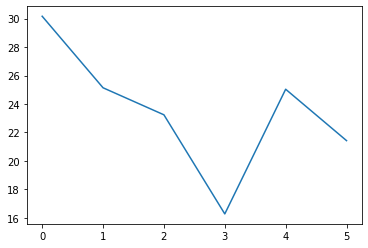

In [16]:
# Plot forecast variance
plt.plot(gm_yhat.variance.values[-1, :])
plt.show()

In [17]:
print(gm_fit.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2938.10
Distribution:                  Normal   AIC:                           5944.20
Method:            Maximum Likelihood   BIC:                           6113.78
                                        No. Observations:                 1083
Date:                Fri, Apr 01 2022   Df Residuals:                     1083
Time:                        19:12:33   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.9013      2.926      1.333      0.182 [ -1.833,  9.63

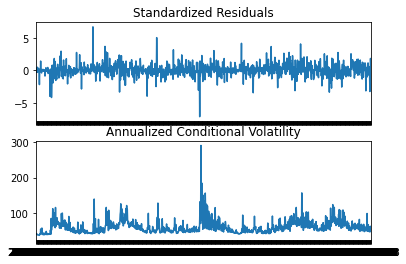

In [50]:
fig = gm_fit.plot(annualize="D")

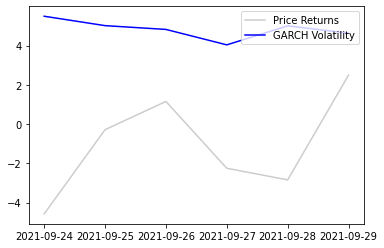

In [18]:
# Plotting estimated GARCH volatility against actual price returns
garch_vol = pd.DataFrame(np.sqrt(gm_yhat.variance.values[-1:]).transpose())
garch_vol.index = test.index
garch_vol.rename(columns={0: "Volatility"})

# Plot the actual Bitcoin returns
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.plot(test['Return'], color = 'grey', alpha = 0.4, label = 'Price Returns')

# Plot ARCH estimated variance
plt.plot(garch_vol, color = 'blue', label = 'GARCH Volatility')

plt.legend(loc = 'upper right')
plt.show()

In [19]:
# Backtest model with MAE, MSE
print("GARCH")
evaluate(test.sub(test.mean()).pow(2), garch_vol**2)

GARCH
Mean Absolute Error (MAE): 17.701
Mean Squared Error (MSE): 338.5


(17.701411533008088, 338.49973306495934)

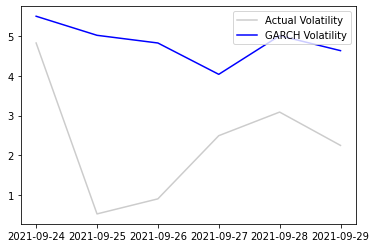

In [22]:
# Plotting estimated GARCH volatility against actual volatility
# Plot the actual Bitcoin volatility
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.plot(actual_vol['Volatility'], color = 'grey', alpha = 0.4, label = 'Actual Volatility')

# Plot ARCH estimated volatility
plt.plot(garch_vol, color = 'blue', label = 'GARCH Volatility')

plt.legend(loc = 'upper right')
plt.show()

In [54]:
param_list = [[1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6]]
hypertune("gjr_garch", "mae", param_list, time_horizon)

Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evalua

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.06913871

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa


Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Fu

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evalua

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa


Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Fu

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterati

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.06913871

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.8192092

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa


Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Fu

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
   

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.49131767

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.49131767

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(



Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 28

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa


Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 28

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.02757803

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evalua

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 28

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.025218877

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.025218877

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(



Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Fu

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.02757803

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 21

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
   

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.06913871

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.2350604

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
   

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 28

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(



Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Fu

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.025218877

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.2350604

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 28

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(



Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Fu

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.025218877

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.31049189

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.2350604

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.06913871

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
   

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 28

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.8192092

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.49131767

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
   

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.2350604

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
   

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(



Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Fu

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 2802.8204232548887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2802.8204232548565
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.02757803

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Mean Absolute Error (MAE): 13.549
Mean Squared Error (MSE): 211.84
Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 2803.5160772777167
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2802.8250160286366
Iteration:     16,   Func. Count:    127,   Neg. LLF: 2802.8227760166983
Iteration:     17,   Func. Count:    134,   Neg. LLF: 2802.820465369612
Iteration:     18,   Func. Count:    141,   Neg. LLF: 2802.8204232548565
Iteration:     19,   Func. Count:    147,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


(1, 1, 1)

In [23]:
# Specify GJR-GARCH model assumptions
gjr_gm = arch_model(train, p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't')

# Fit model
gjr_gm_fit = gjr_gm.fit()

# Forecast the test set
gjr_gm_yhat = gjr_gm_fit.forecast(horizon=time_horizon)

# Print model fitting summary
print(gjr_gm_fit.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 25294.069138712337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17815.235060444025
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3622.819209276342
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3695.3104918911513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3587.0275780310867
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3529.4913176763953
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3408.43836972064
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3555.0252188773484
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2812.789092714965
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3252.9622563519747
Iteration:     11,   Func. Count:     89,   Neg. LLF: 2804.272166206636
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2804.098881344982
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2804.0749165674574
Iteration:     14,   Func. Count:    112,   Neg. LLF: 280

/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


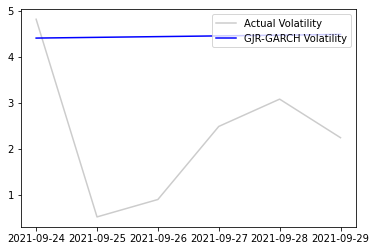

In [24]:
# Plotting estimated ARCH volatility against actual volatility
gjrgm_vol = pd.DataFrame(np.sqrt(gjr_gm_yhat.variance.values[-1:]).transpose())
gjrgm_vol.index = test.index
gjrgm_vol = gjrgm_vol.rename(columns={0: "Volatility"})

# Plot the actual Bitcoin volatility
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.plot(actual_vol['Volatility'], color = 'grey', alpha = 0.4, label = 'Actual Volatility')

# Plot GJR-GARCH estimated volatility
plt.plot(gjrgm_vol, color = 'blue', label = 'GJR-GARCH Volatility')

plt.legend(loc = 'upper right')
plt.show()

In [25]:
# Print each models BIC
print(f'GJR-GARCH BIC: {gjr_gm_fit.bic}')

GJR-GARCH BIC: 5647.565787991719


In [26]:
# Backtest model with MAE, MSE
print("GJR-GARCH")
evaluate(test.sub(test.mean()).pow(2), gjrgm_vol**2)

GJR-GARCH
Mean Absolute Error (MAE): 13.97
Mean Squared Error (MSE): 219.029


(13.969818530869487, 219.02899384212344)

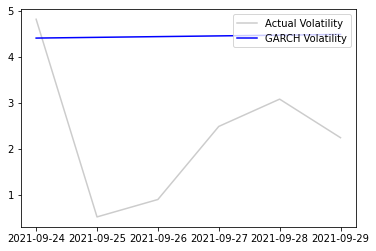

In [28]:
# Plotting estimated GJR-GARCH volatility against actual volatility
# Plot the actual Bitcoin volatility
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.plot(actual_vol['Volatility'], color = 'grey', alpha = 0.4, label = 'Actual Volatility')

# Plot GJR-GARCH estimated volatility
plt.plot(gjrgm_vol, color = 'blue', label = 'GARCH Volatility')

plt.legend(loc = 'upper right')
plt.show()